In [9]:
# This script reads in flare summary and avg 1m data and outputs single flares (defined as
# continaining start, peak, end, and post) flux and time values

import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib
import datetime 
#from astropy import Time


In [10]:
#load in file, 
# downloaded from https://www.ncei.noaa.gov/products/goes-r-extreme-ultraviolet-xray-irradiance 

file1='sci_xrsf-l2-flsum_g18_s20220905_e20250329_v2-2-0.nc' 
file2 ='sci_xrsf-l2-avg1m_g18_s20220902_e20250329_v2-2-0.nc'
flsum= nc.Dataset(file1)
avgm = nc.Dataset(file2)

#vars1 = flsum.variables.keys() #info in
#vars2 = avgm.variables.keys()


In [11]:
#useful variables
flsum_date     = nc.num2date(flsum['time'][:],flsum['time'].units,only_use_cftime_datetimes=False)
avgm_date      = nc.num2date(avgm['time'][:],avgm['time'].units,only_use_cftime_datetimes=False)
flux           = np.ma.filled(avgm['xrsb_flux'], np.nan)
flsum_status   = np.ma.filled(flsum['status'], np.nan)
flsumflux      = np.ma.filled(flsum['xrsb_flux'], np.nan)
flsumbkg       = np.ma.filled(flsum['background_flux'], np.nan)

<ipython-input-11-efc545d28665>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flsum_date     = nc.num2date(flsum['time'][:],flsum['time'].units,only_use_cftime_datetimes=False)
<ipython-input-11-efc545d28665>:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  flsum_date     = nc.num2date(flsum['time'][:],flsum['time'].units,only_use_cftime_datetimes=False)
<ipython-input-11-efc545d28665>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecat

In [21]:
#len(flux) / 525600 #checks out to about 2.5 yrs of data

2.5753424657534247

In [23]:
def filter_flares_e_s_p(status):
    # Select events that have, in order: post/end, start, peak
    all_starts = np.array(np.where(status == 'EVENT_START')) 
    starts = np.delete(all_starts, 0) #remove first b/c last of list will be end typically
    
    tmp = np.where(np.logical_or(status[starts-1] == 'POST_EVENT',
                                 status[starts-1] == 'EVENT_END'))
    ends_then_starts = starts[tmp] # note flsum_status[ends_then_starts] is all event starts, not ends

    tmp = np.where(status[ends_then_starts + 1] == 'EVENT_PEAK')
    ends_then_starts_then_peaks = ends_then_starts[tmp]

    tmp = np.where(flsum_status[ends_then_starts_then_peaks + 2] == 'EVENT_END')
    ends_then_starts_then_peaks_then_ends = ends_then_starts_then_peaks[tmp]
    
    tmp = np.where(flsum_status[ends_then_starts_then_peaks_then_ends + 3] == 'POST_EVENT')
    ends_then_starts_then_peaks_then_ends_then_post = ends_then_starts_then_peaks_then_ends[tmp]
##    # This is very easy process to mess up. Check carefully when changing.

    starts = ends_then_starts_then_peaks_then_ends_then_post
    peaks = ends_then_starts_then_peaks_then_ends_then_post + 1
    ends  = ends_then_starts_then_peaks_then_ends_then_post + 2
    posts = ends_then_starts_then_peaks_then_ends_then_post + 3
    
    #print(len(np.where(status[starts+3]=='POST_EVENT')[0]))
    return starts, peaks, ends, posts

starts, peaks, ends, posts = filter_flares_e_s_p(flsum_status)


In [27]:
len(flsum_status[posts])

4063

In [38]:
#find indicies of events in the avg1m file to save flux in cuts
# must be done for each event status because flare times vary

avgm_s_inds = []
for ind in starts:
    tmp = np.where(avgm_date == flsum_date[ind])[0][0]
    avgm_s_inds.append(tmp)
    
avgm_pe_inds = []
for ind in peaks:
    tmp = np.where(avgm_date == flsum_date[ind])[0][0]
    avgm_pe_inds.append(tmp)

avgm_e_inds = []
for ind in ends:
    tmp = np.where(avgm_date == flsum_date[ind])[0][0]
    avgm_e_inds.append(tmp)
    
avgm_po_inds = []
for ind in posts:
    tmp = np.where(avgm_date == flsum_date[ind])[0][0]
    avgm_po_inds.append(tmp)
    

    
# could have done list comprehension, but more understandable this way
#also might be sped up as dictionary search
# avgm_date_dict = {val: idx for idx, val in enumerate(avgm_date)}
# avgm_s_inds = [avgm_date_dict[flsum_date[ind]] for ind in starts if flsum_date[ind] in avgm_date_dict]


In [37]:
len(avgm_s_inds)

4063

In [43]:
#verify that this system works

print(flux[avgm_pe_inds[20]])
print(flsumflux[peaks[20]])

2.3160835e-06
2.3160835e-06


In [82]:
start_time = avgm_date[0]

avgm_time = [(dt - start_time).total_seconds() / 60 for dt in avgm_date]

In [89]:
#check worked correctly (add one because start is zero minutes)
len(avgm_date) == (avgm_time[-1] +1)


True

In [99]:
avgm_s_inds[i]


12184

In [105]:
# get start to peak flux from avg1m
#zero out time so ML model doesnt get confused by dates

#for i in range(len(avgm_s_inds)):
# see i = 3 for bad example

i = 5

flare_start_time = avgm_time[avgm_s_inds[i]]

flare_flux_s_pe = flux[avgm_s_inds[i]:avgm_pe_inds[i]]
flare_time_s_pe = np.array(avgm_time[avgm_s_inds[i]:avgm_pe_inds[i]]) - flare_start_time

flare_flux_pe_e = flux[avgm_pe_inds[i]:avgm_e_inds[i]]
flare_time_pe_e = np.array(avgm_time[avgm_pe_inds[i]:avgm_e_inds[i]]) - flare_start_time

flare_flux_pe_po = flux[avgm_pe_inds[i]:avgm_po_inds[i]]
flare_time_pe_po = np.array(avgm_time[avgm_pe_inds[i]:avgm_po_inds[i]])- flare_start_time


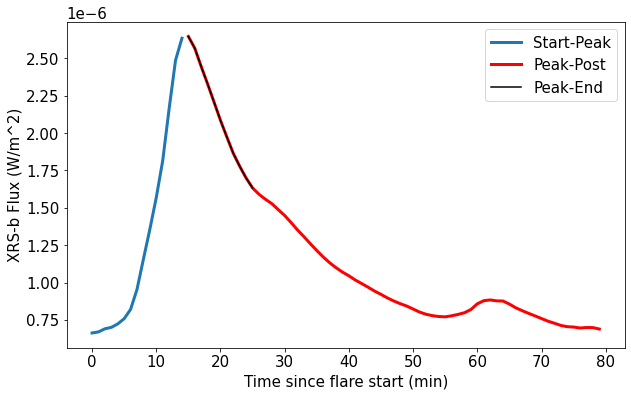

In [125]:
plt.figure(figsize=(10,6))
plt.rcParams['font.size'] = 15
plt.plot(flare_time_s_pe, flare_flux_s_pe, linewidth = 3, label = 'Start-Peak')
plt.plot(flare_time_pe_po, flare_flux_pe_po, linewidth = 3, color = 'red', label = 'Peak-Post')
plt.plot(flare_time_pe_e, flare_flux_pe_e, linewidth = 1.5, color = 'black', label = 'Peak-End')
plt.xlabel('Time since flare start (min)')
plt.ylabel('XRS-b Flux (W/m^2)')
plt.legend()